# 1. Daten einlesen

In [73]:
# Importiere die benötigten Bibliotheken
import pandas as pd
import sqlite3

# Konfiguration
CSV_FILE = "Daten.csv"  # Pfad zur CSV-Datei
DB_FILE = "Test.db"     # Pfad zur SQLite-Datenbank
TABLE_NAME = "Daten"    # Name der Tabelle in der Datenbank

# CSV-Datei laden
df = pd.read_csv(CSV_FILE, sep=';', decimal=',')  # Passe Trennzeichen und Dezimalzeichen an
print(f"Anzahl der Zeilen: {len(df)}")
print(f"Spaltentitel: {list(df.columns)}\n")

print("\nFormat der Datenspalten:")
for col, dtype in zip(df.columns, df.dtypes):
    print(f"{col}: {dtype}")

# Verbindung zur SQLite-Datenbank herstellen (oder erstellen, falls nicht vorhanden)
conn = sqlite3.connect(DB_FILE)

# Daten in die Datenbank schreiben
df.to_sql(TABLE_NAME, conn, if_exists='replace', index=False)
print(f"Daten wurden in die Tabelle '{TABLE_NAME}' geschrieben.\n")

# Verbindung schließen
conn.close()

Anzahl der Zeilen: 1000000
Spaltentitel: ['TimeStamp', 'ActualPos', 'ActualForce', 'Nahtnummer', 'LaserPwr', 'Befehl']


Format der Datenspalten:
TimeStamp: object
ActualPos: float64
ActualForce: int64
Nahtnummer: object
LaserPwr: int64
Befehl: object
Daten wurden in die Tabelle 'Daten' geschrieben.



# 2. Daten -  Bereinigung (Grob)

In [74]:
import sqlite3
import pandas as pd

# Verbindung zur SQLite-Datenbank herstellen
db_file = "Test.db"
table_name = "Daten"
conn = sqlite3.connect(db_file)

# Daten aus der Tabelle 'Daten' lesen
df = pd.read_sql(f"SELECT * FROM {table_name}", conn)

# Sicherstellen, dass die Spalten die gewünschten Datentypen haben
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], errors='coerce')
df['ActualPos'] = pd.to_numeric(df['ActualPos'], errors='coerce')
df['ActualForce'] = pd.to_numeric(df['ActualForce'], errors='coerce')
df['LaserPwr'] = pd.to_numeric(df['LaserPwr'], errors='coerce')
df['Nahtnummer'] = df['Nahtnummer'].astype(str)
df['Befehl'] = df['Befehl'].astype(str)

# Anzahl der Zeilen vor dem Entfernen von None- oder NaN-Werten
initial_row_count = len(df)

# Entfernen von Zeilen mit None- oder NaN-Werten
df = df.dropna()

# Entfernen von Zeilen, in denen der Befehl None ist
df = df[df['Befehl'] != 'None']

# Anzahl der gelöschten Zeilen
removed_row_count = initial_row_count - len(df)
print(f"Anzahl der gelöschten Zeilen (None/NaN oder Befehl=None): {removed_row_count}")

# Überprüfen, ob die Konvertierungen erfolgreich waren
print("\nÜberprüfung nach Konvertierung:")
for col, dtype in zip(df.columns, df.dtypes):
    print(f"{col}: {dtype}")

# Bereinigte Daten erneut in die Tabelle 'Daten' schreiben
df.to_sql(table_name, conn, if_exists='replace', index=False)
print(f"\nBereinigte Daten wurden in die Tabelle '{table_name}' geschrieben.")

# Verbindung schließen
conn.close()

Anzahl der gelöschten Zeilen (None/NaN oder Befehl=None): 1075

Überprüfung nach Konvertierung:
TimeStamp: datetime64[ns, UTC]
ActualPos: float64
ActualForce: int64
Nahtnummer: object
LaserPwr: int64
Befehl: object

Bereinigte Daten wurden in die Tabelle 'Daten' geschrieben.


# 3. Daten visualisieren (Histogramm - ungefiltert)

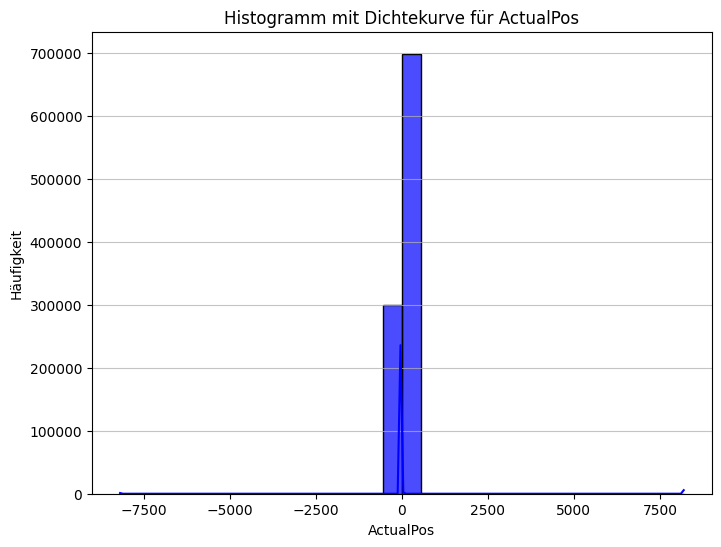

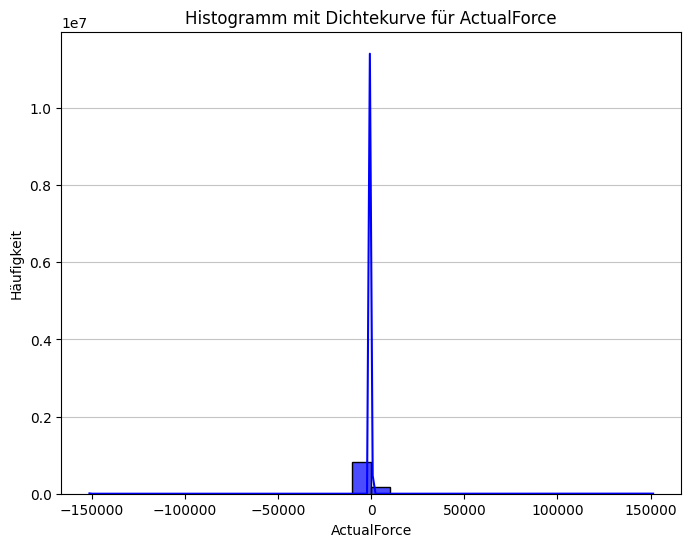

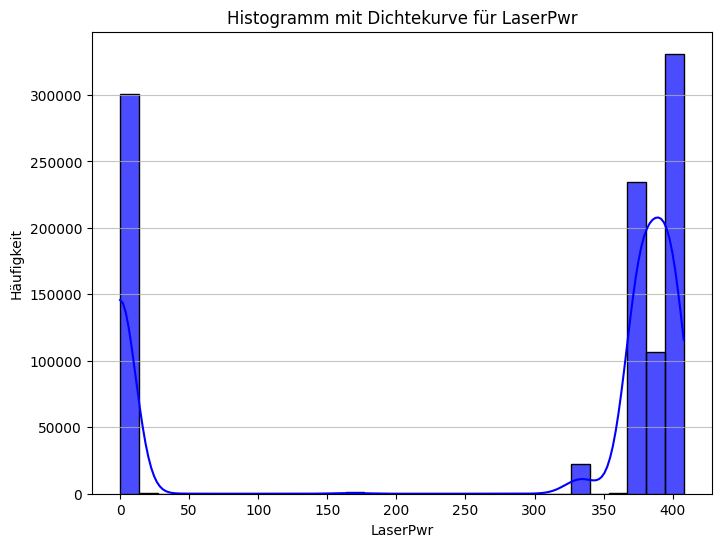

In [75]:
# Importiere die benötigten Bibliotheken
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Konfiguration
db_file = "Test.db"  # Pfad zur SQLite-Datenbank
table_name = "Daten"  # Name der Tabelle in der Datenbank

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect(db_file)

# Daten aus der Tabelle 'Daten' lesen
df = pd.read_sql(f"SELECT * FROM {table_name}", conn)

# Verbindung schließen
conn.close()

# Erstelle ein Histogramm mit Dichtekurve für jede numerische Spalte
numeric_columns = df.select_dtypes(include=['number']).columns

for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], bins=30, kde=True, color='blue', alpha=0.7)
    plt.title(f"Histogramm mit Dichtekurve für {col}")
    plt.xlabel(col)
    plt.ylabel("Häufigkeit")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# 4. Daten -  Bereinigung (Fein)

In [76]:
import sqlite3
import pandas as pd

# Konfiguration
db_file = "Test.db"  # Pfad zur SQLite-Datenbank
table_name = "Daten"  # Name der Tabelle in der Datenbank

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect(db_file)

# Daten aus der Tabelle 'Daten' lesen
df = pd.read_sql(f"SELECT * FROM {table_name}", conn)

# Anzahl der Zeilen vor der Bereinigung
initial_row_count = len(df)
print(f"Anzahl der Zeilen vor der Verfeinerung: {initial_row_count}")

# Definiere die Limiten für die numerischen Spalten
limits = {
    "ActualPos": (-2500, 2500),  # Beispiel: Werte zwischen -2500 und 2500
    "ActualForce": (-1000, 1000),  # Beispiel: Werte zwischen -1000 und 1000
    "LaserPwr": (0, 500)  # Werte zwischen 0 und 500 (inklusive)
}

# Entferne Werte außerhalb der definierten Grenzen
for col, (lower, upper) in limits.items():
    if col in df.columns:
        df = df[(df[col] >= lower) & (df[col] <= upper)]

# Anzahl der Zeilen nach der Bereinigung
final_row_count = len(df)
print(f"Anzahl der Zeilen nach der Verfeinerung: {final_row_count}")

# Anzahl der entfernten Zeilen
removed_row_count = initial_row_count - final_row_count
print(f"Anzahl der entfernten Zeilen: {removed_row_count}")

# Bereinigte Daten erneut in die Tabelle 'Daten' schreiben
df.to_sql(table_name, conn, if_exists='replace', index=False)
print(f"Bereinigte Daten wurden in die Tabelle '{table_name}' geschrieben.")

# Verbindung schließen
conn.close()

Anzahl der Zeilen vor der Verfeinerung: 998925
Anzahl der Zeilen nach der Verfeinerung: 997953
Anzahl der entfernten Zeilen: 972
Bereinigte Daten wurden in die Tabelle 'Daten' geschrieben.


# 5. Daten visualisieren (Histogramm - gefiltert)

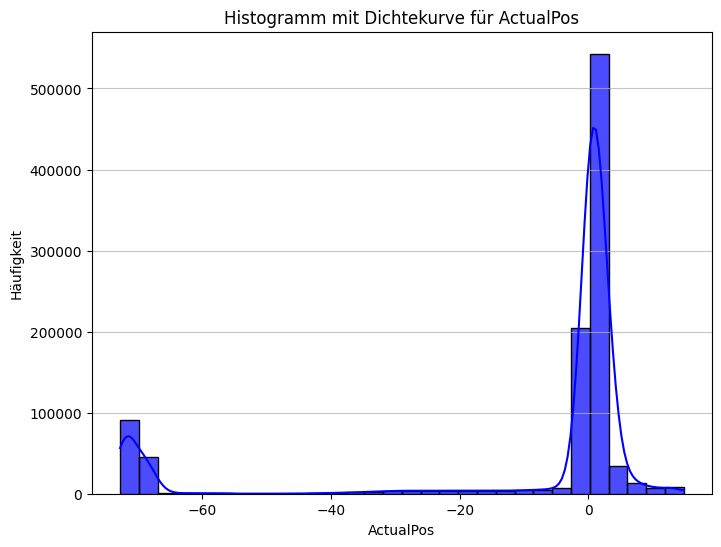

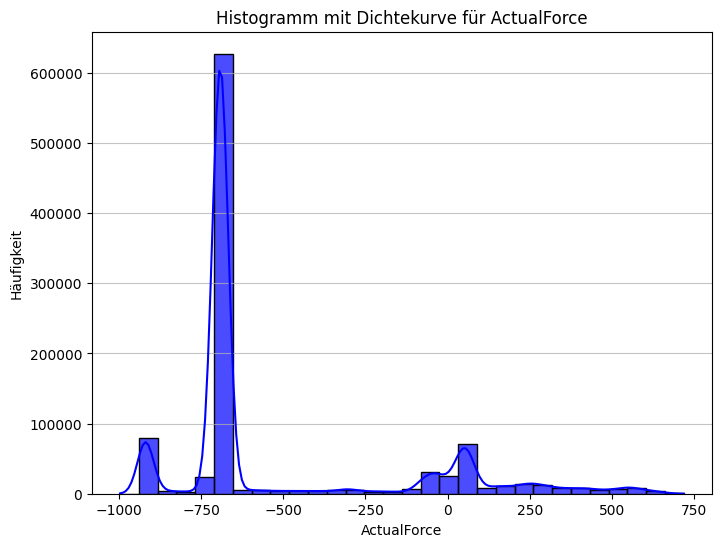

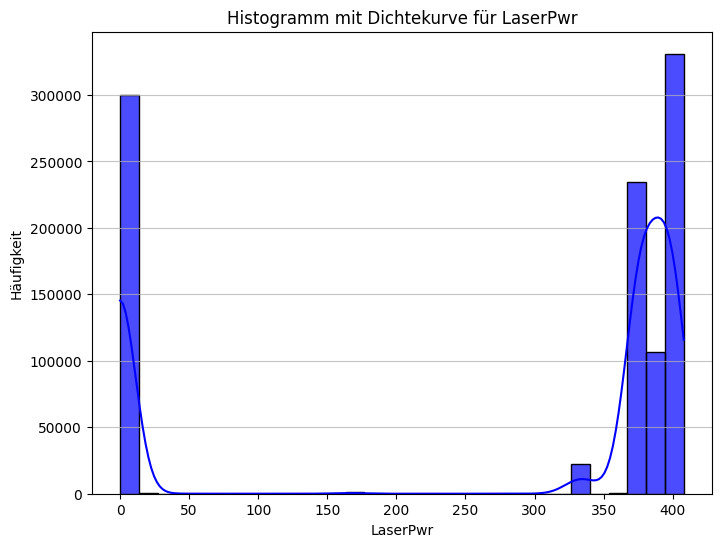

In [77]:
# Importiere die benötigten Bibliotheken
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Konfiguration
db_file = "Test.db"  # Pfad zur SQLite-Datenbank
table_name = "Daten"  # Name der Tabelle in der Datenbank

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect(db_file)

# Daten aus der Tabelle 'Daten' lesen
df = pd.read_sql(f"SELECT * FROM {table_name}", conn)

# Verbindung schließen
conn.close()

# Erstelle ein Histogramm mit Dichtekurve für jede numerische Spalte
numeric_columns = df.select_dtypes(include=['number']).columns

for col in numeric_columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[col], bins=30, kde=True, color='blue', alpha=0.7)
    plt.title(f"Histogramm mit Dichtekurve für {col}")
    plt.xlabel(col)
    plt.ylabel("Häufigkeit")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# 6. Nummerische Analyse

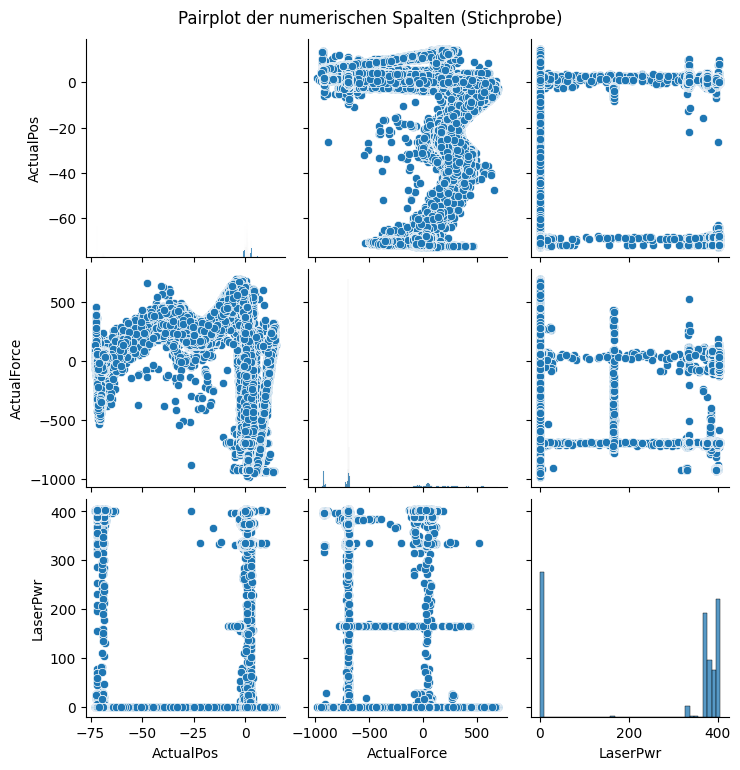

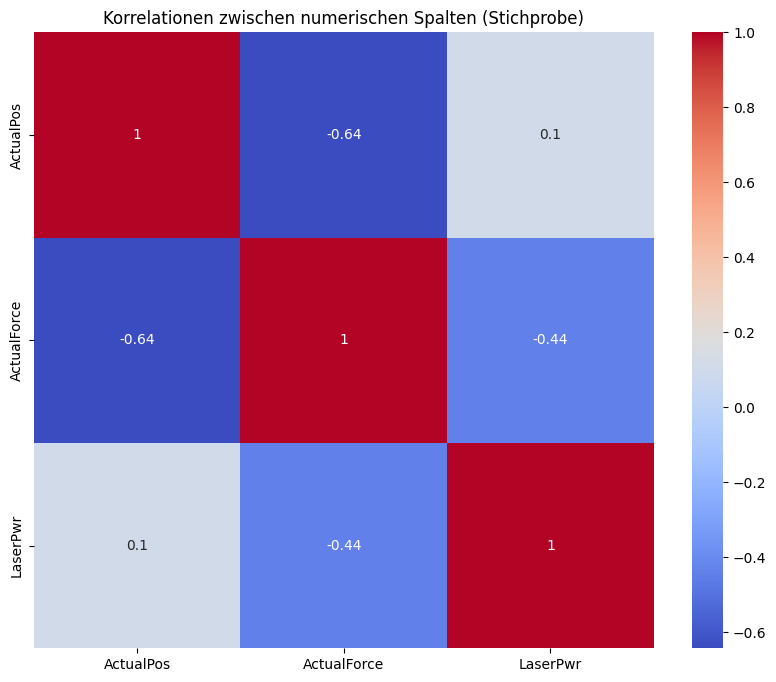

In [78]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Konfiguration
db_path = 'Test.db'
table_name = 'Daten'

# Verbindung zur SQLite-Datenbank herstellen und Daten laden
conn = sqlite3.connect(db_path)
data = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

# Numerische Spalten identifizieren
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Stichprobe der Daten nehmen (50% der Daten)
sample_data = data.sample(frac=0.5, random_state=42)

# Funktion 1: Pairplot der numerischen Spalten
def visualize_sample_data(sample_data, numerical_columns):
    if len(numerical_columns) > 0:
        sns.pairplot(sample_data[numerical_columns])
        plt.suptitle("Pairplot der numerischen Spalten (Stichprobe)", y=1.02)
        plt.show()
    else:
        print("Keine numerischen Spalten für die Visualisierung gefunden.")

# Funktion 2: Alternative Visualisierungen (Heatmap und Histogramme)
def alternative_visualizations_sample(sample_data, numerical_columns):
    if len(numerical_columns) > 0:
        # Heatmap der Korrelationen
        plt.figure(figsize=(10, 8))
        sns.heatmap(sample_data[numerical_columns].corr(), annot=True, cmap='coolwarm')
        plt.title("Korrelationen zwischen numerischen Spalten (Stichprobe)")
        plt.show()
    else:
        print("Keine numerischen Spalten für alternative Visualisierungen gefunden.")

# Aufruf der Visualisierungsfunktionen
visualize_sample_data(sample_data, numerical_columns)
alternative_visualizations_sample(sample_data, numerical_columns)

# 7. Daten visualisieren (Häufigkeit Befehle)

Anzahl der verschiedenen Befehle: 121


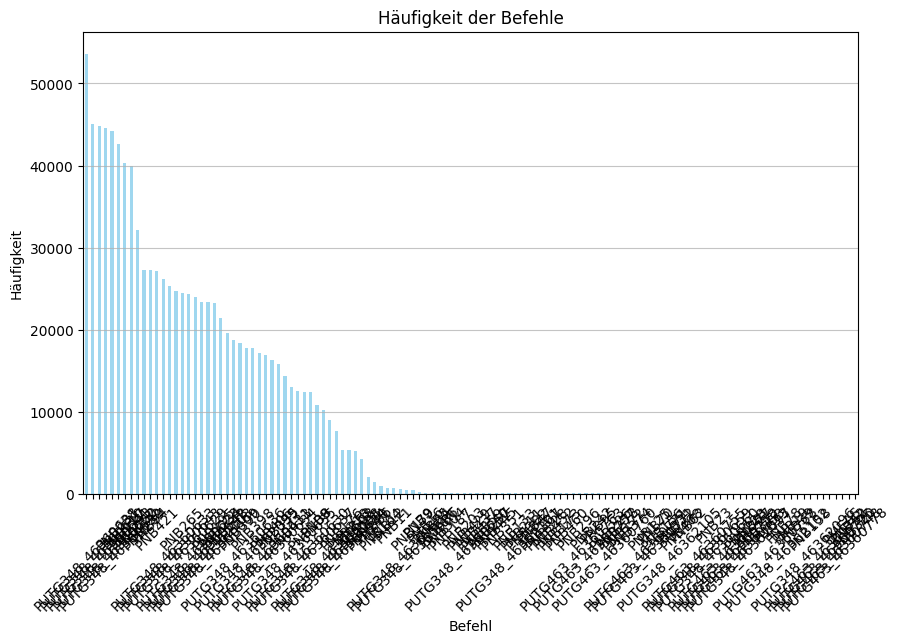

In [79]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Konfiguration
db_path = 'Test.db'
table_name = 'Daten'

# Verbindung zur SQLite-Datenbank herstellen und Daten laden
conn = sqlite3.connect(db_path)
data = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

# Anzahl der verschiedenen Befehle berechnen
unique_commands_count = data['Befehl'].nunique()
print(f"Anzahl der verschiedenen Befehle: {unique_commands_count}")

# Häufigkeit der Befehle berechnen
command_counts = data['Befehl'].value_counts()

# Histogramm der Häufigkeit der Befehle erstellen
plt.figure(figsize=(10, 6))
command_counts.plot(kind='bar', color='skyblue', alpha=0.8)
plt.title("Häufigkeit der Befehle")
plt.xlabel("Befehl")
plt.ylabel("Häufigkeit")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

# 8. Daten visualisieren (Häufigkeit Nahtnummern)

Anzahl der verschiedenen Nahtnummern: 64


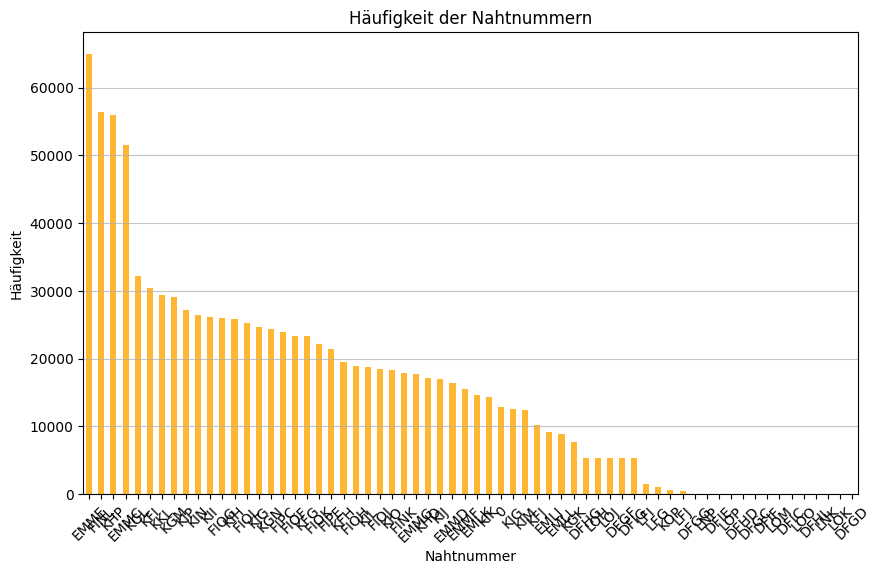

In [80]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Konfiguration
db_path = 'Test.db'
table_name = 'Daten'

# Verbindung zur SQLite-Datenbank herstellen und Daten laden
conn = sqlite3.connect(db_path)
data = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

# Anzahl der verschiedenen Nahtnummern berechnen
unique_nahtnummer_count = data['Nahtnummer'].nunique()
print(f"Anzahl der verschiedenen Nahtnummern: {unique_nahtnummer_count}")

# Häufigkeit der Nahtnummern berechnen
nahtnummer_counts = data['Nahtnummer'].value_counts()

# Histogramm der Häufigkeit der Nahtnummern erstellen
plt.figure(figsize=(10, 6))
nahtnummer_counts.plot(kind='bar', color='orange', alpha=0.8)
plt.title("Häufigkeit der Nahtnummern")
plt.xlabel("Nahtnummer")
plt.ylabel("Häufigkeit")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.show()

# 9. Analyse Befehlszugehörigkeit zu Nahtnummer

In [81]:
import sqlite3
import pandas as pd

# Konfiguration
db_path = 'Test.db'
table_name = 'Daten'
new_table_name = 'Befehle'

# Verbindung zur SQLite-Datenbank herstellen
conn = sqlite3.connect(db_path)

# Daten aus der Tabelle 'Daten' lesen
data = pd.read_sql(f"SELECT * FROM {table_name}", conn)

# Gruppieren nach Befehl und Anzahl der eindeutigen Nahtnummern berechnen
befehl_nahtnummern = data.groupby('Befehl')['Nahtnummer'].nunique()

# Ergebnisse als Liste oder DataFrame speichern (ohne Filter)
befehl_nahtnummern_df = befehl_nahtnummern.reset_index()
befehl_nahtnummern_df.columns = ['Befehl', 'Anzahl eindeutiger Nahtnummern']

# Gruppieren nach der Anzahl eindeutiger Nahtnummern und Zählen der Befehle
anzahl_befehle_pro_verbindung = befehl_nahtnummern_df.groupby('Anzahl eindeutiger Nahtnummern').size().reset_index(name='Anzahl Befehle')

# Anzahl der Befehle mit nur einer Nahtnummer-Zuweisung
befehle_mit_einer_nahtnummer = anzahl_befehle_pro_verbindung[anzahl_befehle_pro_verbindung['Anzahl eindeutiger Nahtnummern'] == 1]['Anzahl Befehle'].sum()

# Gesamtanzahl der Befehle
gesamtanzahl_befehle = befehl_nahtnummern_df['Befehl'].nunique()

# Ergebnisse ausgeben
print("Anzahl der Befehle mit einer bestimmten Anzahl eindeutiger Nahtnummern:")
print(anzahl_befehle_pro_verbindung.to_string(index=False))
print(f"\nAnzahl der Befehle mit nur einer Nahtnummer-Zuweisung: {befehle_mit_einer_nahtnummer}")
print(f"Gesamtanzahl der Befehle: {gesamtanzahl_befehle}")

# Befehle mit nur einer Nahtnummerzuweisung identifizieren
befehle_mit_einer_nahtnummer_liste = befehl_nahtnummern[befehl_nahtnummern == 1].index

# Daten filtern, um nur die Zeilen mit diesen Befehlen zu behalten
gefilterte_daten = data[data['Befehl'].isin(befehle_mit_einer_nahtnummer_liste)]

# Anzahl der Zeilen in der neuen Tabelle
anzahl_zeilen_neue_tabelle = len(gefilterte_daten)

# Gesamtanzahl der Zeilen in der Tabelle 'Daten'
gesamtanzahl_zeilen_daten = len(data)

# Relativer Prozentanteil der Zeilen in der neuen Tabelle
relativer_prozentanteil = (anzahl_zeilen_neue_tabelle / gesamtanzahl_zeilen_daten) * 100

# Gefilterte Daten in die neue Tabelle 'Befehle' schreiben
gefilterte_daten.to_sql(new_table_name, conn, if_exists='replace', index=False)

# Ergebnisse ausgeben
print(f"\nAnzahl der Zeilen in der neuen Tabelle '{new_table_name}': {anzahl_zeilen_neue_tabelle}")
print(f"Gesamtanzahl der Zeilen in der Tabelle '{table_name}': {gesamtanzahl_zeilen_daten}")
print(f"Relativer Prozentanteil der Zeilen in der neuen Tabelle: {relativer_prozentanteil:.2f}%")

# Verbindung schließen
conn.close()

Anzahl der Befehle mit einer bestimmten Anzahl eindeutiger Nahtnummern:
 Anzahl eindeutiger Nahtnummern  Anzahl Befehle
                              1              31
                              2              31
                              3              14
                              4              15
                              5               8
                              6               5
                              7               6
                              8               3
                              9               4
                             10               1
                             11               2
                             13               1

Anzahl der Befehle mit nur einer Nahtnummer-Zuweisung: 31
Gesamtanzahl der Befehle: 121

Anzahl der Zeilen in der neuen Tabelle 'Befehle': 6471
Gesamtanzahl der Zeilen in der Tabelle 'Daten': 997953
Relativer Prozentanteil der Zeilen in der neuen Tabelle: 0.65%


In [82]:
import sqlite3
import pandas as pd

# Konfiguration
db_path = 'Test.db'
table_name = 'Daten'

# Verbindung zur SQLite-Datenbank herstellen und Daten laden
conn = sqlite3.connect(db_path)
data = pd.read_sql(f"SELECT * FROM {table_name}", conn)
conn.close()

# Sicherstellen, dass die benötigten Spalten vorhanden sind
required_columns = ['ActualForce', 'LaserPwr', 'Befehl']
if not all(col in data.columns for col in required_columns):
    raise ValueError(f"Die folgenden Spalten fehlen in den Daten: {set(required_columns) - set(data.columns)}")

# 1. Befehle finden, bei denen ActualForce und LaserPwr den Wert 0 haben
filtered_commands = data[(data['ActualForce'] == 0) & (data['LaserPwr'] == 0)]['Befehl'].unique()
print("Befehle, bei denen ActualForce und LaserPwr den Wert 0 haben:")
print(filtered_commands)

# 2. Wertebereich der ausgewählten Befehle berechnen
selected_df = data[data['Befehl'].isin(filtered_commands)]

# Gruppieren nach Befehl und Min/Max für jede numerische Spalte berechnen
numeric_columns = ['ActualForce', 'LaserPwr']  # Füge hier weitere numerische Spalten hinzu, falls nötig
range_per_command = selected_df.groupby('Befehl')[numeric_columns].agg(['min', 'max'])

# Ergebnisse anzeigen
print("\nWertebereich (Min/Max) pro ausgewähltem Befehl:")
print(range_per_command)

Befehle, bei denen ActualForce und LaserPwr den Wert 0 haben:
['PNB195' 'PNB421' 'PNB218' 'PNB117' 'PNB289' 'PNB343' 'PNB382' 'PNB148'
 'PNB53' 'PNB101' 'PNB176' 'PNB140' 'PNB413' 'PNB16' 'PNB304' 'PNB281'
 'PNB8' 'PNB94' 'PNB351' 'PNB11' 'PNB109' 'PNB359' 'PUTG348_46362105'
 'PNB296' 'PNB452']

Wertebereich (Min/Max) pro ausgewähltem Befehl:
                 ActualForce      LaserPwr     
                         min  max      min  max
Befehl                                         
PNB101                  -922  469        0  329
PNB109                  -926  356        0  402
PNB11                   -146  303        0   20
PNB117                  -973  598        0  402
PNB140                  -705  582        0  397
PNB148                  -878  201        0  405
PNB16                   -444  252        0    0
PNB176                  -134  226        0    0
PNB195                  -693  497        0  407
PNB218                  -420  335        0    0
PNB281                  -942  3

# 10. 3D-Visualisierung (Nummerische Werte pro Befehl)

In [83]:
import os
import sqlite3
import pandas as pd
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Konfiguration
db_path = 'Test.db'
table_name = 'Daten'
output_folder = "Bilder"
columns = ['ActualPos', 'ActualForce', 'LaserPwr']  # Spalten für die Visualisierung

# Verbindung zur SQLite-Datenbank herstellen
try:
    conn = sqlite3.connect(db_path)
    filtered_data = pd.read_sql_query(f"SELECT * FROM {table_name}", conn)
    print(f"Daten aus der Tabelle '{table_name}' erfolgreich geladen.")
except Exception as e:
    print(f"Fehler beim Laden der Daten: {e}")
    exit(1)
finally:
    conn.close()

# Ordner für die gespeicherten Bilder erstellen
os.makedirs(output_folder, exist_ok=True)

# Iteriere über alle Befehle
unique_commands = filtered_data['Befehl'].unique()
created_graphs = 0
too_few_points = 0

for command in unique_commands:
    # Daten für den aktuellen Befehl filtern
    command_data = filtered_data[filtered_data['Befehl'] == command].copy()

    # Sicherstellen, dass die benötigten Spalten vorhanden sind
    missing_columns = [col for col in columns if col not in command_data.columns]
    if missing_columns:
        print(f"Spalten {missing_columns} fehlen für Befehl '{command}'. Überspringe.")
        continue

    # Überprüfen, ob genügend Datenpunkte vorhanden sind
    if len(command_data) <= 5:
        too_few_points += 1
        print(f"Befehl '{command}' hat zu wenige Datenpunkte ({len(command_data)}). Überspringe.")
        continue

    # IsolationForest nur auf die numerischen Spalten anwenden
    try:
        iso_forest = IsolationForest(contamination=0.05, random_state=42)
        command_data['anomaly'] = iso_forest.fit_predict(command_data[columns])
    except Exception as e:
        print(f"Fehler bei IsolationForest für Befehl '{command}': {e}")
        continue

    # 3D-Plot erstellen
    try:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # Normalpunkte (anomaly = 1)
        normal_data = command_data[command_data['anomaly'] == 1]
        ax.scatter(normal_data['ActualPos'], normal_data['ActualForce'], normal_data['LaserPwr'], 
                   c='b', marker='o', alpha=0.5, label='Normal')

        # Anomalien (anomaly = -1)
        anomalies = command_data[command_data['anomaly'] == -1]
        ax.scatter(anomalies['ActualPos'], anomalies['ActualForce'], anomalies['LaserPwr'], 
                   c='r', marker='x', alpha=0.8, label='Anomalien')

        # Achsen und Titel setzen
        ax.set_xlabel('ActualPos')
        ax.set_ylabel('ActualForce')
        ax.set_zlabel('LaserPwr')
        ax.set_title(f"3D-Darstellung mit Anomalien für Befehl '{command}'")
        ax.legend()

        # Bild speichern
        output_path = os.path.join(output_folder, f"3D_Graph_Befehl_{command}.png")
        plt.savefig(output_path)
        plt.close(fig)  # Schließt die Figur, um Speicher zu sparen

        created_graphs += 1
        print(f"3D-Graph für Befehl '{command}' wurde gespeichert.")
    except Exception as e:
        print(f"Fehler beim Erstellen des 3D-Plots für Befehl '{command}': {e}")

# Zusammenfassung ausgeben
print(f"\nZusammenfassung:")
print(f"Anzahl erstellter Graphen: {created_graphs}")
print(f"Anzahl Befehle mit zu wenigen Datenpunkten: {too_few_points}")

Daten aus der Tabelle 'Daten' erfolgreich geladen.
3D-Graph für Befehl 'PUTG348_46362103' wurde gespeichert.
3D-Graph für Befehl 'PNB398' wurde gespeichert.
3D-Graph für Befehl 'PUTG348_46360609' wurde gespeichert.
3D-Graph für Befehl 'PNB117' wurde gespeichert.
3D-Graph für Befehl 'PNB195' wurde gespeichert.
3D-Graph für Befehl 'PUTG348_46360610' wurde gespeichert.
3D-Graph für Befehl 'PUTG348_46360622' wurde gespeichert.
3D-Graph für Befehl 'PNB343' wurde gespeichert.
3D-Graph für Befehl 'PUTG348_46360623' wurde gespeichert.
3D-Graph für Befehl 'PNB250' wurde gespeichert.
3D-Graph für Befehl 'PNB265' wurde gespeichert.
3D-Graph für Befehl 'PNB390' wurde gespeichert.
3D-Graph für Befehl 'PUTG348_46360608' wurde gespeichert.
3D-Graph für Befehl 'PUTG348_46362099' wurde gespeichert.
3D-Graph für Befehl 'PUTG348_46360632' wurde gespeichert.
3D-Graph für Befehl 'PUTG348_46360638' wurde gespeichert.
3D-Graph für Befehl 'PNB109' wurde gespeichert.
3D-Graph für Befehl 'PNB335' wurde gespeich